In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-09-19 08:27:43--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.3’

housing.csv.3       100%[===================>]   1.36M  --.-KB/s    in 0.008s  

2023-09-19 08:27:43 (164 MB/s) - ‘housing.csv.3’ saved [1423529/1423529]



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [3]:
df = pd.read_csv("housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Simple EDA

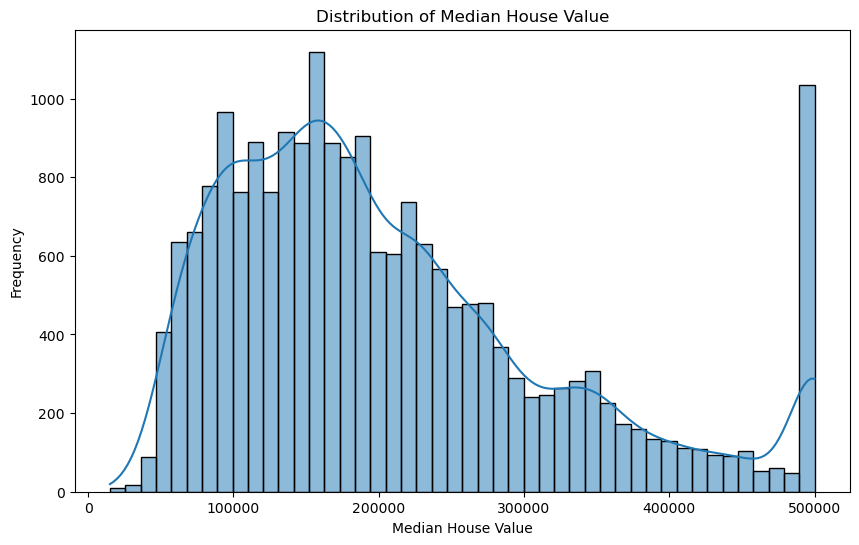

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df['median_house_value'], kde=True)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

In [5]:
selected_ocean_proximity = ['<1H OCEAN', 'INLAND']
df_use= df[df['ocean_proximity'].isin(selected_ocean_proximity)]

# Use only the specified columns
selected_columns = ['latitude', 'longitude', 'housing_median_age', 'total_rooms',
                    'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
df_use = df_use[selected_columns]

In [6]:
missing_values = df_use.isnull().sum()
missing_values[missing_values > 0]

total_bedrooms    157
dtype: int64

In [7]:
df_use['population'].median()

1195.0

/var/tmp/ipykernel_105636/165725626.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log1p(df_use.median_house_value))


<Axes: xlabel='median_house_value', ylabel='Density'>

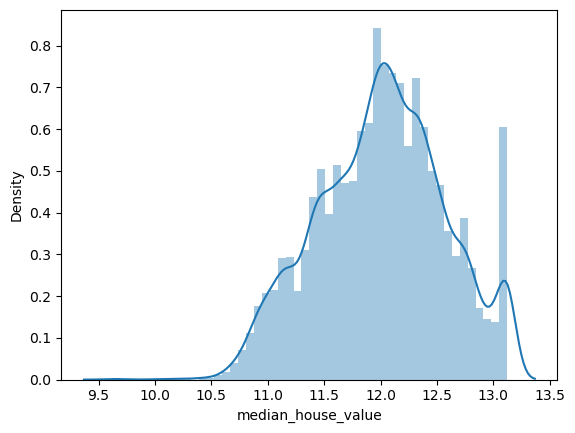

In [8]:
sns.distplot(np.log1p(df_use.median_house_value))

# Train Valid Test Split

In [9]:
df_use = df_use.sample(frac=1, random_state=42)

X = df_use.drop('median_house_value', axis=1)
y = df_use['median_house_value']

y = np.log1p(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train shapes: X_train - {}, y_train - {}".format(X_train.shape, y_train.shape))
print("Validation shapes: X_val - {}, y_val - {}".format(X_val.shape, y_val.shape))
print("Test shapes: X_test - {}, y_test - {}".format(X_test.shape, y_test.shape))

Train shapes: X_train - (9412, 8), y_train - (9412,)
Validation shapes: X_val - (3137, 8), y_val - (3137,)
Test shapes: X_test - (3138, 8), y_test - (3138,)


# Linear Regression

In [10]:
def prep(df, fillna_value):
    df = df.fillna(fillna_value)
    X = df.values
    return X

In [11]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [12]:
X_mean_train = prep(X_train, fillna_value=X_train.total_bedrooms.mean())
X_zero_train = prep(X_train, fillna_value=0)

In [13]:
X_mean_val = prep(X_val, fillna_value=X_train.total_bedrooms.mean())
X_zero_val = prep(X_val, fillna_value=0)

In [14]:
reg_mean= LinearRegression()
reg_mean.fit(X_mean_train, y_train)
y_pred_mean = reg_mean.predict(X_mean_val)
print(np.round(rmse(y_val, y_pred_mean),2))

0.35


In [15]:
reg_zero= LinearRegression()
reg_zero.fit(X_zero_train, y_train)
y_pred_zero = reg_zero.predict(X_zero_val)
print(np.round(rmse(y_val, y_pred_zero),2))

0.35


# L1 Regularization with Lasso Regression

In [16]:
r=[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [17]:
X_zero_train = prep(X_train, fillna_value=0)
X_zero_val = prep(X_val, fillna_value=0)

In [18]:
for i in r:
    reg = linear_model.Lasso(alpha=i)
    reg.fit(X_zero_train, y_train)
    y_pred = reg.predict(X_zero_val)
    print(i,np.round(rmse(y_val, y_pred),2))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.249e+02, tolerance: 2.988e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

0 0.35
1e-06 0.35
0.0001 0.35
0.001 0.35
0.01 0.35
0.1 0.39
1 0.55
5 0.56
10 0.56


# Seed

In [19]:
seeds=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [20]:
rmse_list=[]

for seed in seeds:

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

    
    
    X_zero_train = prep(X_train, fillna_value=0)
    X_zero_val = prep(X_val, fillna_value=0)
    
    reg = LinearRegression()
    reg.fit(X_zero_train, y_train)
    
    
    
    y_pred = reg.predict(X_zero_val)
    
    rmse_val = np.round(rmse(y_val, y_pred),2)
    
    rmse_list.append(rmse_val)
    
    print(seed, rmse_val)
     

0 0.34
1 0.34
2 0.34
3 0.34
4 0.35
5 0.34
6 0.34
7 0.34
8 0.36
9 0.34


In [23]:
round(np.std(rmse_list), 3)

0.006

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [26]:
X_zero_train = prep(X_train, fillna_value=0)
X_zero_test = prep(X_test, fillna_value=0)

In [27]:
reg = linear_model.Lasso(alpha=0.001)
reg.fit(X_zero_train, y_train)
y_pred = reg.predict(X_zero_test)